In [36]:
import numpy as np
import pandas as pd
import sklearn
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from deap import base, creator, tools, algorithms
from sklearn import svm
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import train_test_split


Importing Data

In [37]:

path='C:/Users/admin/Desktop/datas/'
data=pd.read_csv(path+'fraudcases.csv')
data.columns


Index(['transaction_id', 'transaction_amount', 'card_number',
       'Transaction_date', 'transaction_status', 'atm_ID', 'atm_location',
       'transaction_category', 'time_between_trans', 'isCashPresented',
       'isCashTaken', 'isCashRetracted', 'isCashoutError', 'ExistInHost',
       'is_fraud', 'fraud_reason', 'n_PIN_attempts', 'Organisation',
       'transaction_frequency_per_day', 'transaction_frequency_per_min',
       'year', 'month', 'day', 'hour', 'minute', 'second', 'is_RC_fraud',
       'is_IF_fraud', 'is_CVM_fraud', 'is_PIN_fraud', 'cvm_methods', 'mean',
       'diff', 'is_HM_fraud', 'is_ATML_fraud', 'expiry_date',
       'is_expDate_fraud', 'all_frauds', 'all_fraudsnames', 'distance_time',
       'is_Loc_Discrepancy_fraud', 'issuer_city', 'is_ISSU_fraud',
       'is_unMonth_fraud', 'is_unDay_fraud', 'is_unhour_fraud'],
      dtype='object')

Data Preprocessing 

In [38]:
data.dropna(inplace=True)
data.drop(['is_unDay_fraud', 'is_unMonth_fraud'],axis=1,inplace=True)
data.drop(['year', 'month','day','hour','day','minute','second'],axis=1,inplace=True)

In [39]:

data.drop(['atm_ID', 'atm_location','fraud_reason','Organisation','transaction_frequency_per_day','mean','diff','is_ATML_fraud','all_frauds','all_fraudsnames','distance_time','is_Loc_Discrepancy_fraud','is_ISSU_fraud'],axis=1,inplace=True)


In [40]:
data.columns

Index(['transaction_id', 'transaction_amount', 'card_number',
       'Transaction_date', 'transaction_status', 'transaction_category',
       'time_between_trans', 'isCashPresented', 'isCashTaken',
       'isCashRetracted', 'isCashoutError', 'ExistInHost', 'is_fraud',
       'n_PIN_attempts', 'transaction_frequency_per_min', 'is_RC_fraud',
       'is_IF_fraud', 'is_CVM_fraud', 'is_PIN_fraud', 'cvm_methods',
       'is_HM_fraud', 'expiry_date', 'is_expDate_fraud', 'issuer_city',
       'is_unhour_fraud'],
      dtype='object')

In [41]:
hour_freq = data['transaction_frequency_per_min'] * 60
data["transaction_frequency_per_hour"]= hour_freq

In [42]:
data.drop(["transaction_frequency_per_min"],axis= 1,inplace=True)

In [43]:


def generate_expiry_diff(data):
    expiry_dates = []
    expiry_diffs = []

    for index, row in data.iterrows():
        transaction_date = pd.to_datetime(row['Transaction_date'])

        random_year = random.randint(1, 4)
        random_month = random.randint(1, 12)
        random_day = random.randint(1, 30)
        random_hour = random.randint(0, 23)
        random_minute = random.randint(0, 59)
        random_second = random.randint(0, 59)

        if random.random() < 0.11:  # 11% chance of generating an invalid expiry date
            new_expiry_date = transaction_date + timedelta(
                days=random_day,
                hours=random_hour,
                minutes=random_minute,
                seconds=random_second
            )
        else:
            new_expiry_date = transaction_date - timedelta(
                days=random_day,
                hours=random_hour,
                minutes=random_minute,
                seconds=random_second
            )

        expiry_dates.append(new_expiry_date)
        expiry_diff = (transaction_date - new_expiry_date).total_seconds() / 60
        expiry_diffs.append(expiry_diff)

    return expiry_dates , expiry_diffs


# Call the function to generate expiry dates and differences
expiry_dates , expiry_diffs = generate_expiry_diff(data)



In [44]:
data['expiry_date'] = expiry_dates
data['exp_diff'] = expiry_diffs

In [45]:
# Assuming you have a DataFrame called 'df' containing the sub-target variables
# Create a new column 'is_fraud' with 1 if more than 3 sub-target variables are 1, else 0
data['is_fraud'] = (data[['is_PIN_fraud', 'is_HM_fraud', 'is_RC_fraud', 'is_expDate_fraud',
                     'is_IF_fraud', 'is_CVM_fraud', 'is_unhour_fraud']].sum(axis=1) > 2).astype(int)


In [46]:

data2=data.loc[data['is_fraud']==1]
data1=data.loc[data['is_fraud']==0].iloc[:20000]
data3=pd.concat([data1,data2]).reset_index(drop=True)


In [47]:
data5=data3.drop(['is_RC_fraud','is_IF_fraud', 'is_CVM_fraud','is_unhour_fraud','is_expDate_fraud','is_HM_fraud','is_PIN_fraud'],axis=1)
data5 = data5.sample(frac=1, random_state=42)
data5.reset_index(drop=True, inplace=True)

In [48]:
data5.drop(['Transaction_date','card_number','expiry_date','transaction_id'],axis=1,inplace=True)

In [49]:
data5.columns

Index(['transaction_amount', 'transaction_status', 'transaction_category',
       'time_between_trans', 'isCashPresented', 'isCashTaken',
       'isCashRetracted', 'isCashoutError', 'ExistInHost', 'is_fraud',
       'n_PIN_attempts', 'cvm_methods', 'issuer_city',
       'transaction_frequency_per_hour', 'exp_diff'],
      dtype='object')

In [50]:
data5.drop(['is_fraud'],axis=1,inplace=True)

Data Encoding

In [51]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the categorical feature
data5['issuer_city'] = label_encoder.fit_transform(data5['issuer_city'])
data5['transaction_category'] = label_encoder.fit_transform(data5['transaction_category'])


Data Scaling 

In [52]:
scaler = StandardScaler()
scaler.fit(data5)
data5_scaled = scaler.transform(data5)

K_means: hyperparameter tuning 

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

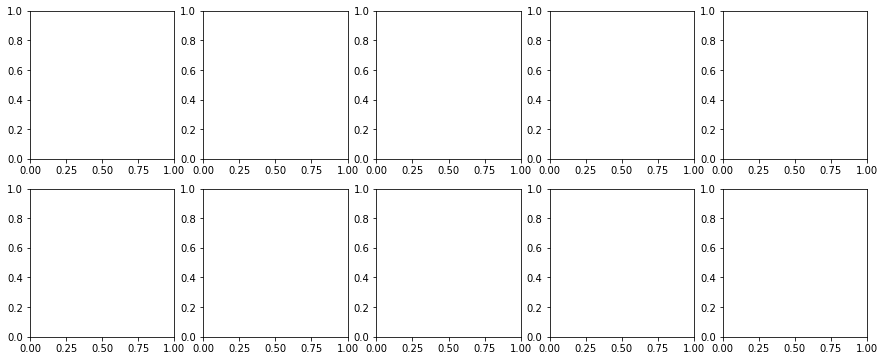

In [53]:

# Create an array to store the Calinski-Harabasz scores for each 'n_clusters' value
ch_scores = []

# Create a subplot for each 'n_clusters' value
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.ravel()

# Iterate through 'n_clusters' values from 1 to 10
for n_clusters in range(1, 11):
    # Fit K-means with the current 'n_clusters' value
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data5_scaled)
    labels = kmeans.labels_
    ch_score = 0
    # Calculate the Calinski-Harabasz score and store it
    if len(np.unique(labels)) > 1:
        # Calculate the Calinski-Harabasz score and store it
        ch_score = sklearn.metrics.davies_bouldin_score(data5_scaled, labels)
        ch_scores.append(ch_score)
    ch_scores.append(ch_score)

Text(0.5, 1.0, 'num clusters Vs davies_bouldin_score')

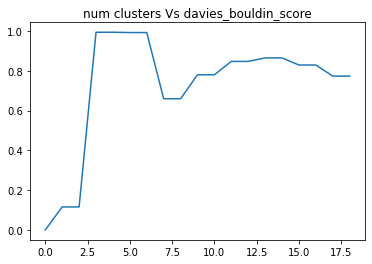

In [54]:
plt.plot(ch_scores)
plt.title('num clusters Vs davies_bouldin_score')

kmeans results

In [56]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data5_scaled)
labels = kmeans.labels_

C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


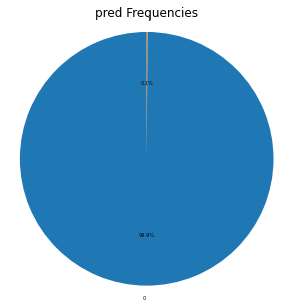

In [57]:

pred_counts=pd.Series(labels).value_counts()
pred_counts.plot.pie(figsize=(5, 5), autopct='%1.1f%%', startangle=90,fontsize=5)

plt.title('pred Frequencies')
plt.axis('equal')
plt.show()

In [58]:

#  Calculate the Calinski-Harabasz Index
score = calinski_harabasz_score(data5_scaled, labels)

print("Calinski-Harabasz Index:", score)

Calinski-Harabasz Index: 6446.172444297582


In [59]:
dbi = davies_bouldin_score(data5_scaled, labels)
print("davies_bouldin_score:", dbi)

davies_bouldin_score: 0.11547805743320672


SVM:Hyperparameter tuning 

In [60]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data5_scaled, train_size=0.8)

In [61]:
# Define the DEAP creator and individual classes
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the hyperparameter search space
hyperparameter_space = {
    'nu': [0.01, 0.05, 0.1, 0.2],
    'kernel': ['rbf','sigmoid','poly'],
    'gamma': [0.1, 1, 10]
}

# Define functions to generate individuals and populations
def generate_individual():
    print('individual:')
    print(random.choice(hyperparameter_space['nu']),
            random.choice(['rbf', 'sigmoid', 'linear']),  # Choose from valid kernels
            random.choice(hyperparameter_space['gamma']))
    print('\n')
    return [random.choice(hyperparameter_space['nu']),
            random.choice(['rbf', 'sigmoid', 'linear']),  # Choose from valid kernels
            random.choice(hyperparameter_space['gamma'])]


def generate_population(n):
    print('generation')
    print(generate_individual() for _ in range(n))
    print('\n')
    return [generate_individual() for _ in range(n)]

# Define the evaluation function (fitness function)
def evaluate_individual(individual):
    nu, kernel, gamma = individual
    score = 0
    if (kernel in ['rbf', 'sigmoid', 'linear']) and (nu in [0.01, 0.05, 0.1, 0.2]) and (gamma in [0.1, 1, 10]):
        model = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
        model.fit(train_data)
        labels = model.predict(test_data)
        score = calinski_harabasz_score(test_data, labels)
    return score,

# Create a DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[0, 0, 0], up=[4, 1, 2], indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create an initial population
population = toolbox.population(n=10)

# Run the genetic algorithm
result, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=10, lambda_=20,
                                            cxpb=0.7, mutpb=0.3, ngen=20, stats=None,
                                            halloffame=None, verbose=True)

# Get the best individual (hyperparameters)
best_individual = tools.selBest(result, k=1)[0]

# Train the model with the best hyperparameters
nu, kernel, gamma = best_individual
best_model = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
best_model.fit(train_data)

# Make predictions on the test set
pred = best_model.predict(test_data)


C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\admin\AppData\Roaming\Python\Python310\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


individual:
0.2 rbf 0.1


individual:
0.01 sigmoid 10


individual:
0.2 rbf 1


individual:
0.1 sigmoid 1


individual:
0.2 linear 1


individual:
0.1 rbf 1


individual:
0.01 rbf 10


individual:
0.05 linear 0.1


individual:
0.01 sigmoid 0.1


individual:
0.2 linear 1


gen	nevals
0  	10    
1  	20    
2  	20    
3  	20    
4  	20    
5  	20    
6  	20    
7  	20    
8  	20    
9  	20    
10 	20    
11 	20    
12 	20    
13 	20    
14 	20    
15 	20    
16 	20    
17 	20    
18 	20    
19 	20    
20 	20    


One class : SVM results

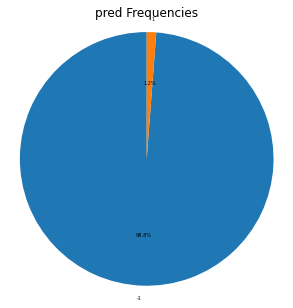

In [62]:

pred_counts=pd.Series(pred).value_counts()
pred_counts.plot.pie(figsize=(5, 5), autopct='%1.1f%%', startangle=90,fontsize=5)

plt.title('pred Frequencies')
plt.axis('equal')
plt.show()

In [63]:

#  Calculate the Calinski-Harabasz Index
score = calinski_harabasz_score(test_data, pred)

print("Calinski-Harabasz Index:", score)

Calinski-Harabasz Index: 392.5743318567422


In [64]:

dbi = davies_bouldin_score(test_data, pred)
print("davies_bouldin_score:", dbi)

davies_bouldin_score: 1.9319310714665405
